<a href="https://colab.research.google.com/github/alexdel1/HackGoogleAI/blob/main/UBernTest1over2_Delode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Alexandre Delode
##Research Positions in Machine Learning and Computer Vision
###June 19, 2024

### Task  1

Import the required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt



Preprocess the dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Define image size
image_size = 64

# Load the dataset
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset = dataset['train'].shuffle(1000).take(80)  # Use 80 images for training
test_dataset = dataset['train'].shuffle(1000).skip(80).take(20)  # Use 20 images for testing

# Preprocess function
def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocess function and batch the datasets
batch_size = 32
train_dataset = train_dataset.map(preprocess).batch(batch_size)
test_dataset = test_dataset.map(preprocess).batch(batch_size)

# Convert train dataset to numpy arrays
train_images = []
train_labels = []
for images, labels in tfds.as_numpy(train_dataset):
    train_images.append(images)
    train_labels.append(labels)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

# Convert test dataset to numpy arrays
test_images = []
test_labels = []
for images, labels in tfds.as_numpy(test_dataset):
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Print shapes to verify
print('Train images shape:', train_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test images shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Train images shape: (80, 64, 64, 1)
Train labels shape: (80,)
Test images shape: (20, 64, 64, 1)
Test labels shape: (20,)


Add uniform noise for the training set.

In [ ]:
def add_uniform_noise(images, noise_factor=0.2):
    noisy_images = images + noise_factor * np.random.uniform(low=-1.0, high=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_train_images = add_uniform_noise(train_images)


Create one model that includes the encoder and the decoder.

In [ ]:
from tensorflow.keras import layers, Model, losses, callbacks

# Define image size
image_size = 64

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(image_size, image_size, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(18, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(18, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Build and summarize the autoencoder
autoencoder = Denoise()
input_img = tf.keras.Input(shape=(image_size, image_size, 1))
output_img = autoencoder(input_img)
autoencoder_model = Model(input_img, output_img)
autoencoder_model.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 denoise (Denoise)           (None, 64, 64, 1)         13961     
                                                                 
Total params: 13961 (54.54 KB)
Trainable params: 13961 (54.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The structure has been taken from the tensorflow tutorial. It has been adapted to fit a 64 x 64 image. The hyperparameters could have been optimised with optuna.


In [ ]:

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

# Train the autoencoder with a history callback
history = autoencoder_model.fit(noisy_train_images, train_images,
                epochs=500,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                callbacks=[early_stopping])


Epoch 1/500
5/5 [==============================] - 2s 139ms/step - loss: 0.0758 - val_loss: 0.0489
Epoch 2/500
5/5 [==============================] - 0s 89ms/step - loss: 0.0736 - val_loss: 0.0482
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: 0.0696 - val_loss: 0.0480
Epoch 4/500
5/5 [==============================] - 1s 112ms/step - loss: 0.0658 - val_loss: 0.0436
Epoch 5/500
5/5 [==============================] - 1s 150ms/step - loss: 0.0603 - val_loss: 0.0382
Epoch 6/500
5/5 [==============================] - 1s 144ms/step - loss: 0.0534 - val_loss: 0.0321
Epoch 7/500
5/5 [==============================] - 1s 158ms/step - loss: 0.0455 - val_loss: 0.0261
Epoch 8/500
5/5 [==============================] - 1s 142ms/step - loss: 0.0375 - val_loss: 0.0196
Epoch 9/500
5/5 [==============================] - 1s 138ms/step - loss: 0.0306 - val_loss: 0.0173
Epoch 10/500
5/5 [==============================] - 1s 102ms/step - loss: 0.0261 - val_loss: 0.0160
Epoch 11/50

The test data are kept in a "vault" and not used for the training.


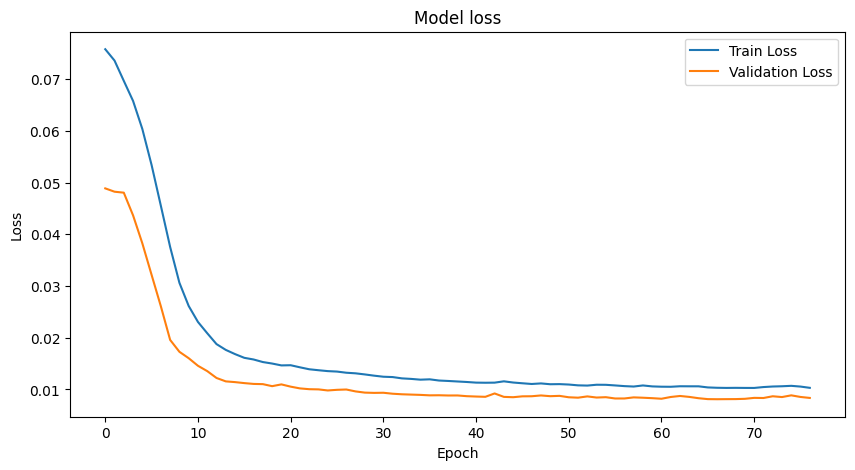

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

There is a plateau. The training is stopped before overfitting.

In [ ]:
def add_gaussian_noise(images, noise_factor=0.2):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

noisy_test_images = add_gaussian_noise(test_images)

Gaussian noise is added to the test set.

In [ ]:
# Predict denoised images
denoised_images = autoencoder_model.predict(noisy_test_images)

1/1 [==============================] - 0s 336ms/step


In [ ]:
from skimage.metrics import mean_squared_error, structural_similarity

# Calculate MSE for each image in the test set
mse_values = [mean_squared_error(original, reconstructed) for original, reconstructed in zip(test_images, denoised_images)]

# Calculate SSIM for each image in the test set
ssim_values = [structural_similarity(original.reshape(64, 64), reconstructed.reshape(64, 64), data_range=reconstructed.max() - reconstructed.min()) for original, reconstructed in zip(test_images, denoised_images)]

# Calculate MSE for each noisy image in the test set
mse_values_noisy = [mean_squared_error(original, reconstructed) for original, reconstructed in zip(test_images, noisy_test_images)]

# Calculate SSIM for each noisy image in the test set
ssim_values_noisy = [structural_similarity(original.reshape(64, 64), reconstructed.reshape(64, 64), data_range=reconstructed.max() - reconstructed.min()) for original, reconstructed in zip(test_images, noisy_test_images)]

# Print average MSE and SSIM
print("Average MSE noisy:", np.mean(mse_values_noisy))
print("Average SSIM noisy:", np.mean(ssim_values_noisy))

# Print average MSE and SSIM
print("Average MSE denoised:", np.mean(mse_values))
print("Average SSIM denoised:", np.mean(ssim_values))

Average MSE noisy: 0.03308295542824337
Average SSIM noisy: 0.398677768543888
Average MSE denoised: 0.012956395754919631
Average SSIM denoised: 0.4986860144437931


Even if the model is limited in parameters, the training is limited by Colab capabilities and the dataset is relatively small, an improvement can be seen from the MSE and SSIM metrics with MSE divided by more than two and SSIM augmented by 50%.

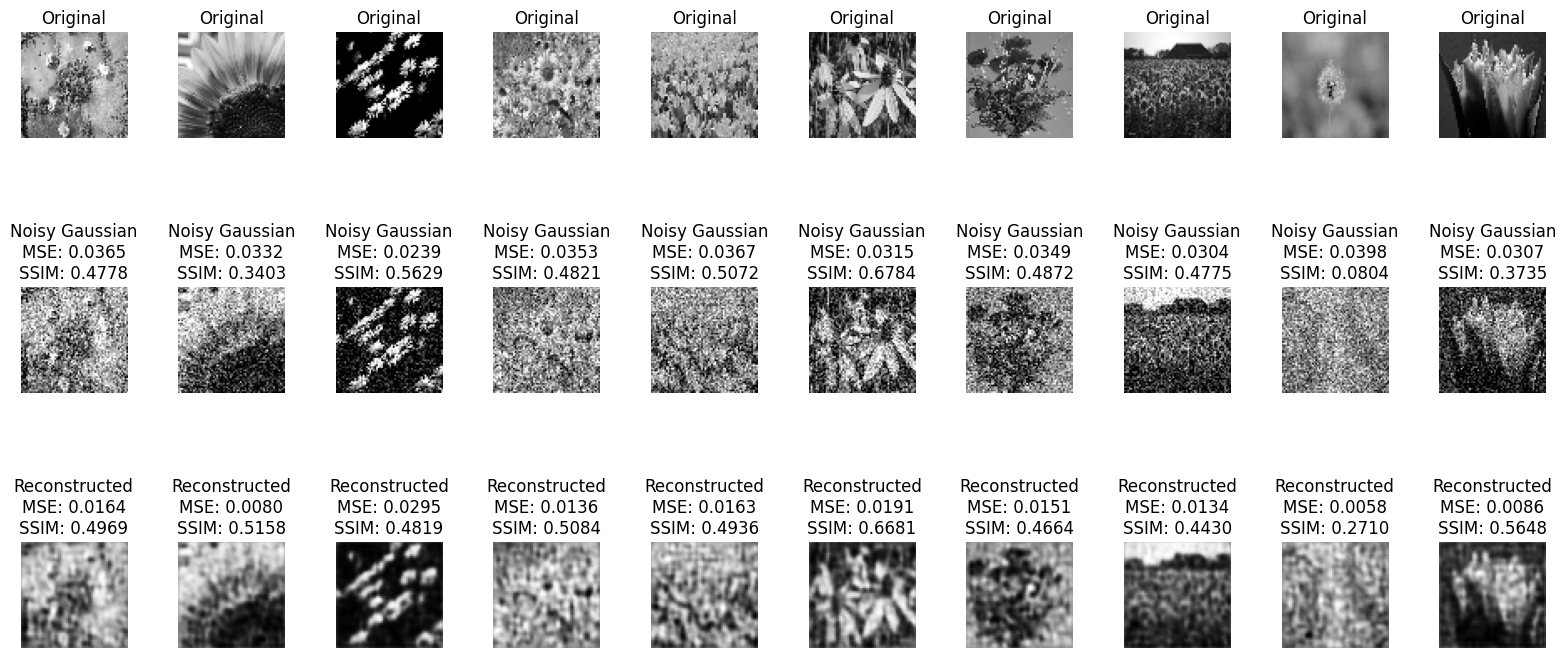

In [ ]:
# Visualize the results
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(test_images[i].reshape(image_size, image_size), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(noisy_test_images[i].reshape(image_size, image_size), cmap='gray')
    plt.title(f"Noisy Gaussian\nMSE: {mse_values_noisy[i]:.4f}\nSSIM: {ssim_values_noisy[i]:.4f}")
    plt.axis('off')

    # Display denoised
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(denoised_images[i].reshape(image_size, image_size), cmap='gray')
    plt.title(f"Reconstructed\nMSE: {mse_values[i]:.4f}\nSSIM: {ssim_values[i]:.4f}")
    plt.axis('off')

plt.show()

We can visually see the improvement from the noisy image to the denoised image compared to the original one.

### Task  2 - First Part

Import the required library

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

Import CIFAR dataset and create train/test sets.

In [ ]:
# Load CIFAR-10 dataset
(x_train, _), (_, _) = cifar10.load_data()

# Take 100 images for the task
images = x_train[:100]
images_test = x_train[100:200]

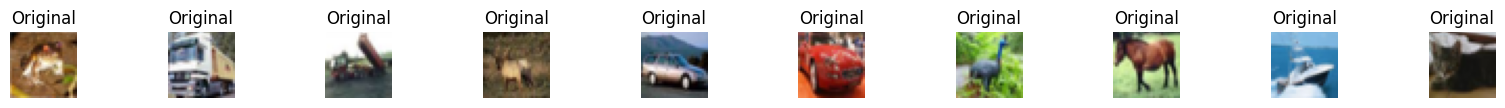

In [ ]:
# Visualize the dataset
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # Display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(images[i])
    plt.title("Original")
    plt.axis('off')

"To make things more interesting, we also augment the images before feeding them to R.": So the data augmentation must be coded as a function.

In [ ]:
def data_augmentation(images):
    # Function to perform data augmentation
    data_aug = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.GaussianNoise(0.1)
    ])
    # Apply augmentation to each image
    augmented_images = np.array([tf.cast(data_aug(image), tf.float32) / 255.0 for image in images])

    return augmented_images

# Augment images
augmented_images = data_augmentation(images)


Visualize the augmented data set.

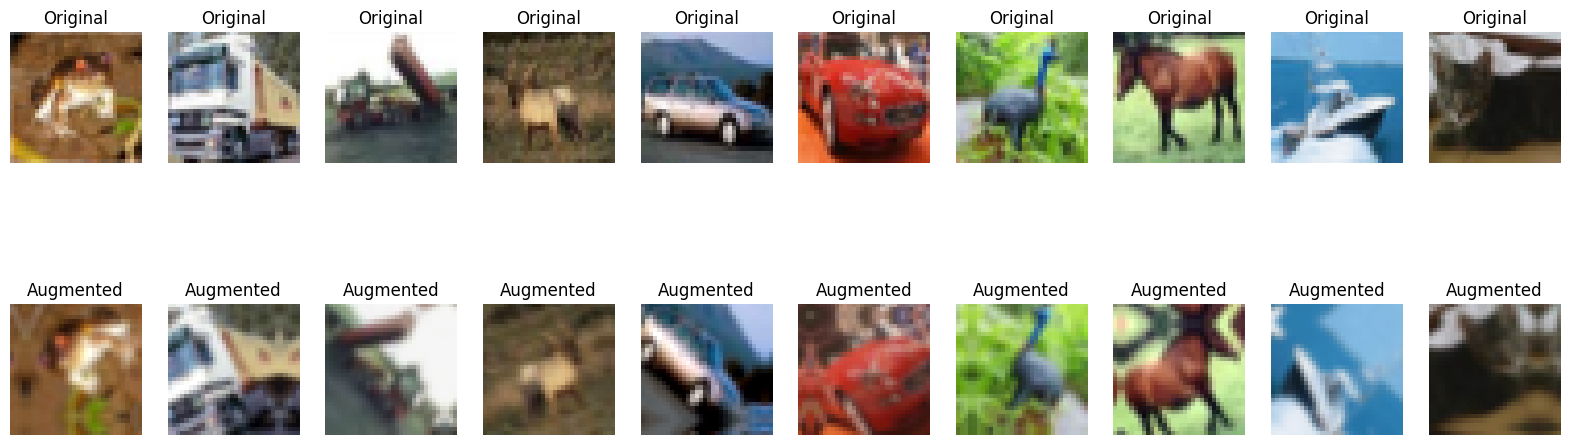

In [ ]:
# Visualize the results
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i])
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis('off')

**Due to a limited amount of time with the only use of Colab, I had to work in a different file that I can't merge in order to keep the compilation. **